1. Download the dataset, inspect classes, create anomaly split

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import h5py
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import label_binarize
from tensorflow.keras import regularizers
import seaborn as sns
from tensorflow.keras.layers import Conv2D, Lambda, MaxPooling2D, BatchNormalization, ReLU, GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Dropout, Flatten, Input, Reshape, Conv2DTranspose, LeakyReLU, UpSampling2D, GaussianNoise, SpatialDropout2D
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras import backend as K

In [ ]:
# # Download Galaxy10 DECaLS (HDF5)
# ! rm ./Galaxy10_DECals_64.h5
# ! wget https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
# data_path = "./Galaxy10_DECals_64.h5"

# print("Downloaded to:", data_path)

rm: cannot remove './Galaxy10_DECals_64.h5': No such file or directory
--2025-12-03 09:06:24--  https://cernbox.cern.ch/remote.php/dav/public-files/RyWK8CBk2yqKR0b/Galaxy10_DECals_64.h5
Resolving cernbox.cern.ch (cernbox.cern.ch)... 137.138.120.151, 128.142.53.28, 128.142.53.35, ...
Connecting to cernbox.cern.ch (cernbox.cern.ch)|137.138.120.151|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 159140118 (152M) [application/octet-stream]
Saving to: ‘Galaxy10_DECals_64.h5’

Galaxy10_DECals_64. 100%[===================>] 151.77M  26.5MB/s    in 6.5s    

2025-12-03 09:06:31 (23.5 MB/s) - ‘Galaxy10_DECals_64.h5’ saved [159140118/159140118]

Downloaded to: ./Galaxy10_DECals_64.h5


In [ ]:
# Load images and labels using h5py
with h5py.File(data_path, "r") as f:
    images = np.array(f["images"])   # shape (17736, 256, 256, 3)
    labels = np.array(f["ans"])      # shape (17736,)

#  normalize pixels in [0,1]
print(f'Before normalization [{images.min()}, {images.max()}]')
images = images / 255
print(f'After normalization [{images.min()}, {images.max()}]')

# 64×64 pixels + 3 channels (R, G, B)
print("Images shape:", images.shape)
print("Labels shape:", labels.shape, "dtype:", labels.dtype)

Before normalization [0, 255]
After normalization [0.0, 1.0]
Images shape: (17736, 64, 64, 3)
Labels shape: (17736,) dtype: uint8


In [ ]:
# Class names from the Galaxy10 DECaLS documentation
class_names = {
    0: "Disturbed Galaxies",
    1: "Merging Galaxies",
    2: "Round Smooth Galaxies",
    3: "In-between Round Smooth Galaxies",
    4: "Cigar Shaped Smooth Galaxies",  # will be 'anomaly'
    5: "Barred Spiral Galaxies",
    6: "Unbarred Tight Spiral Galaxies",
    7: "Unbarred Loose Spiral Galaxies",
    8: "Edge-on Galaxies without Bulge",
    9: "Edge-on Galaxies with Bulge"
}

unique, counts = np.unique(labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

Class distribution:
Class 0 (Disturbed Galaxies): 1081
Class 1 (Merging Galaxies): 1853
Class 2 (Round Smooth Galaxies): 2645
Class 3 (In-between Round Smooth Galaxies): 2027
Class 4 (Cigar Shaped Smooth Galaxies): 334
Class 5 (Barred Spiral Galaxies): 2043
Class 6 (Unbarred Tight Spiral Galaxies): 1829
Class 7 (Unbarred Loose Spiral Galaxies): 2628
Class 8 (Edge-on Galaxies without Bulge): 1423
Class 9 (Edge-on Galaxies with Bulge): 1873


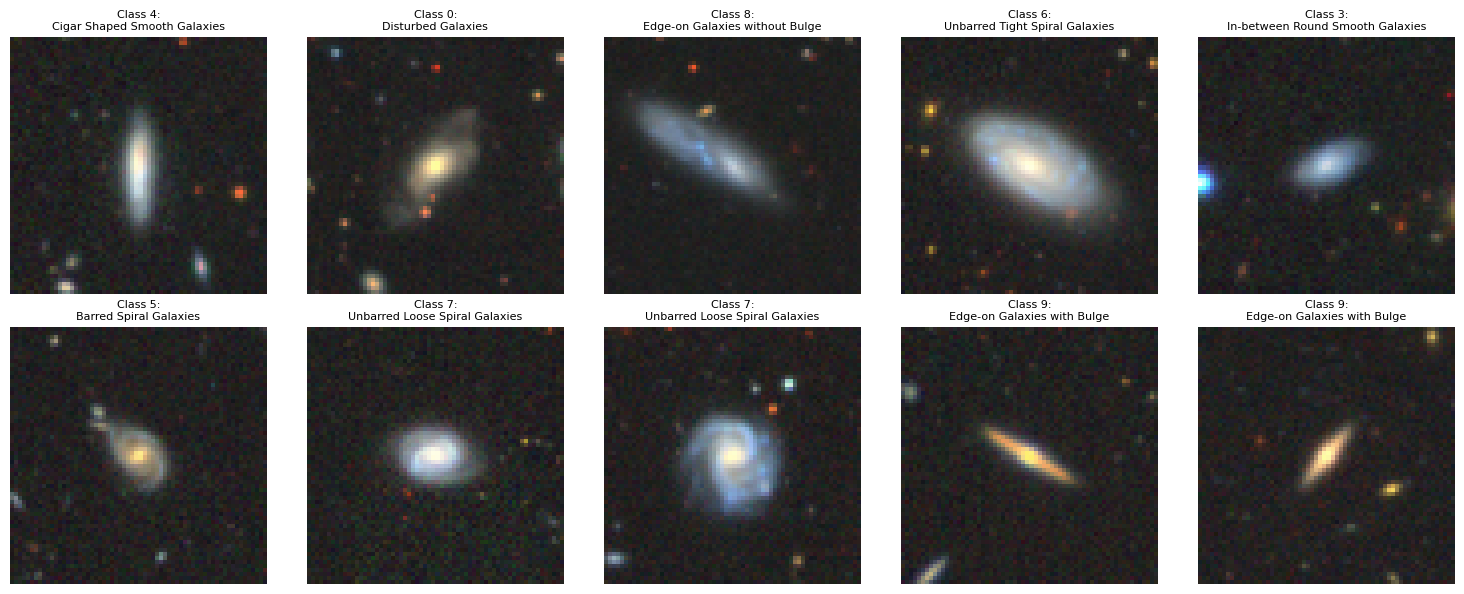

In [ ]:
# Show a grid of sample images from different classes
def show_examples(images, labels, class_names, n_rows=2, n_cols=5):
    plt.figure(figsize=(3*n_cols, 3*n_rows))
    indices = np.random.choice(len(images), size=n_rows*n_cols, replace=False)
    for i, idx in enumerate(indices):
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(images[idx])
        plt.title(f"Class {labels[idx]}:\n{class_names[int(labels[idx])]}", fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

show_examples(images, labels, class_names)

In [ ]:
# Create anomaly dataset: all class 4 images
ANOMALY_CLASS = 0

anomaly_mask = (labels == ANOMALY_CLASS)
standard_mask = ~anomaly_mask

anom_images = images[anomaly_mask]
anom_labels = labels[anomaly_mask]  # all 0, but we keep them for bookkeeping

std_images = images[standard_mask]
std_labels_original = labels[standard_mask]

print("Standard images:", std_images.shape)
print("Anomaly images:", anom_images.shape)

Standard images: (16655, 64, 64, 3)
Anomaly images: (1081, 64, 64, 3)


In [ ]:
# For training, remap standard labels from {0,...,9} -> {0,...,8}
unique_std_classes = sorted(np.unique(std_labels_original))
print("Standard classes (original indices):", unique_std_classes)

# Create mapping dict
label_map = {original: new for new, original in enumerate(unique_std_classes)}
inv_label_map = {v: k for k, v in label_map.items()}

print("Label map (original -> new):", label_map)

std_labels = np.vectorize(label_map.get)(std_labels_original)
print("Remapped standard labels min/max:", std_labels.min(), std_labels.max())
n_classes = len(unique_std_classes)

Standard classes (original indices): [np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)]
Label map (original -> new): {np.uint8(1): 0, np.uint8(2): 1, np.uint8(3): 2, np.uint8(4): 3, np.uint8(5): 4, np.uint8(6): 5, np.uint8(7): 6, np.uint8(8): 7, np.uint8(9): 8}
Remapped standard labels min/max: 0 8


In [ ]:
# Split standard data: 50% train, 25% val, 25% test

# First split: train (50%) and temp (50%)
X_train_std, X_temp_std, y_train_std, y_temp_std = train_test_split(
    std_images,
    std_labels,
    test_size=0.5,
    stratify=std_labels,
    random_state=42
)

# Second split: temp into val (25%) and test (25%) of full standard data
X_val_std, X_test_std, y_val_std, y_test_std = train_test_split(
    X_temp_std,
    y_temp_std,
    test_size=0.5,
    stratify=y_temp_std,
    random_state=42
)

print("Train standard:", X_train_std.shape, y_train_std.shape)
print("Val standard:  ", X_val_std.shape, y_val_std.shape)
print("Test standard: ", X_test_std.shape, y_test_std.shape)
del std_images, std_labels, X_temp_std, y_temp_std

Train standard: (8327, 64, 64, 3) (8327,)
Val standard:   (4164, 64, 64, 3) (4164,)
Test standard:  (4164, 64, 64, 3) (4164,)


2. CNN classifier + ROC curves + confusion matrices

In [ ]:
print(y_train_std[0])
y_train_cat = to_categorical(y_train_std, n_classes)
y_val_cat = to_categorical(y_val_std, n_classes)
y_test_cat = to_categorical(y_test_std, n_classes)
print(y_train_cat[0])

8
[0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.2),
], name="augmentation")

In [ ]:
## CNN classifier
'''
64x64 is a pretty small image, so I wouldn't choose kernels bigger than 5x5 or 7x7
With bigger kernels at the start of the network we aim to achieve a stronger early reduction

For the amount of kernels for each layer we try to follow a common heuristic
                        32 -> 64 -> 128 -> 256 -> 512
Start small and double after each downsampling, the idea behind is that
  ---> Early layers look at small details so fewer filters are needed
  ---> After each max-pool, doubling filters keeps total “information capacity” balanced

Our ideal layer architecture is:
                            Con2D -> BatchNorm -> ReLU -> MaxPool
- Convolution produces arbitrary values, BatchNorm rescales and re-centers them to a stable distribution
- MaxPool with size 2×2, reduces resolution by exactly half
'''
model = keras.Sequential([
    # Apply augmentation only during training
    data_augmentation,

    #### CNN ####
    Conv2D(32, (3, 3), input_shape=(64, 64, 3), padding='same'), # (64, 64, 3)
    BatchNormalization(),
    ReLU(),
    Conv2D(32, (3, 3), padding='same'), # (64, 64, 3)
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)), # (32, 32, 3)

    Conv2D(64, (3, 3), padding='same'), # (32, 32, 3)
    BatchNormalization(),
    ReLU(),
    Conv2D(64, (3, 3), padding='same'), # (32, 32, 3)
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)), # (16, 16, 3)
    Dropout(0.2),

    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)), # (16, 16, 3)
    BatchNormalization(),
    ReLU(),
    Conv2D(128, (3, 3), padding='same', kernel_regularizer=regularizers.l2(1e-4)), # (16, 16, 3)
    BatchNormalization(),
    ReLU(),
    MaxPooling2D(pool_size=(2, 2)), # (8, 8, 3)
    Dropout(0.3),

    #### DNN ####
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax') # 9 standard classes
])
'''
We don't use Flatten() otherwise the Dense head explodes
If we then do Dense(64):
  Parameters = 16,384 × 64 ≈ 1mil
  That’s over 1 million parameters in the first dense layer alone
  With only ~ 8,000 images, this is a recipe for overfitting
'''

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


"\nWe don't use Flatten() otherwise the Dense head explodes\nIf we then do Dense(64):\n  Parameters = 16,384 × 64 ≈ 1mil\n  That’s over 1 million parameters in the first dense layer alone\n  With only ~ 8,000 images, this is a recipe for overfitting\n"

In [ ]:
smoot_enthropy = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)

model.compile(optimizer='adam',
              loss=smoot_enthropy,
              metrics=['accuracy'])

print(X_train_std.shape)
unique, counts = np.unique(y_train_std, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"Class {u} ({class_names[u]}): {c}")

(8327, 64, 64, 3)
Class distribution:
Class 0 (Disturbed Galaxies): 927
Class 1 (Merging Galaxies): 1322
Class 2 (Round Smooth Galaxies): 1013
Class 3 (In-between Round Smooth Galaxies): 167
Class 4 (Cigar Shaped Smooth Galaxies): 1021
Class 5 (Barred Spiral Galaxies): 915
Class 6 (Unbarred Tight Spiral Galaxies): 1314
Class 7 (Unbarred Loose Spiral Galaxies): 712
Class 8 (Edge-on Galaxies without Bulge): 936


In [ ]:
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation (Sequential)       │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_9 (ReLU)                  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_10 (ReLU)                 │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_11 (ReLU)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_12 (ReLU)                 │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_13 (ReLU)                 │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_14 (ReLU)                 │ (None, 16, 16, 128)    │             

 Total params: 917,629 (3.50 MB)

 Trainable params: 305,577 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

 Optimizer params: 611,156 (2.33 MB)

None


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train_std, y_train_cat,
    validation_data=(X_val_std, y_val_cat),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop]
)

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.2624 - loss: 2.0582 - val_accuracy: 0.1587 - val_loss: 3.1767
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.4333 - loss: 1.6801 - val_accuracy: 0.1587 - val_loss: 3.8594
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5073 - loss: 1.5630 - val_accuracy: 0.1623 - val_loss: 3.1973
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5548 - loss: 1.4760 - val_accuracy: 0.3288 - val_loss: 2.0828
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.5940 - loss: 1.4226 - val_accuracy: 0.5019 - val_loss: 1.5362
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.6421 - loss: 1.3248 - val_accuracy: 0.5454 - val_loss: 1.4824
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.6565 - loss: 1.3016 - val_accuracy: 0.6105 - val_loss: 1.3307
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.6840 - loss: 1.2340 - val_acc

In [ ]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test_std, y_test_cat)
print(f'\nTest accuracy: {test_acc}')

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8112 - loss: 0.9504

Test accuracy: 0.820845365524292


In [ ]:
# Plot training & validation accuracy and loss
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

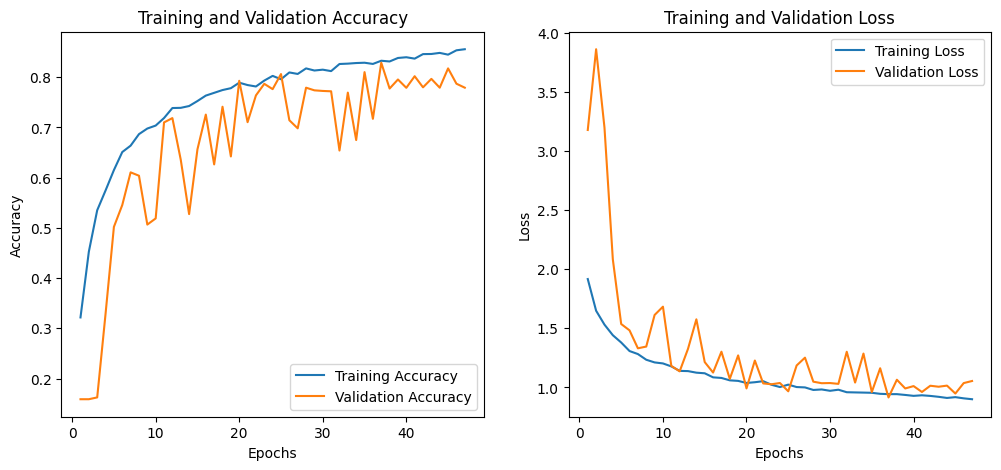

In [ ]:
# Call the function to plot the training history
plot_training_history(history)

In [ ]:
def plot_roc_curves(y_true, y_pred, num_classes=9):
    # Binarize the labels
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    plt.figure(figsize=(12, 8))
    colors = plt.cm.get_cmap('tab10')

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], color=colors(i), lw=2,
                 label=f'Class {i} (AUC = {roc_auc[i]:.3f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Each Class')
    plt.legend(loc='lower right')
    plt.show()

131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


/tmp/ipython-input-671325112.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10')


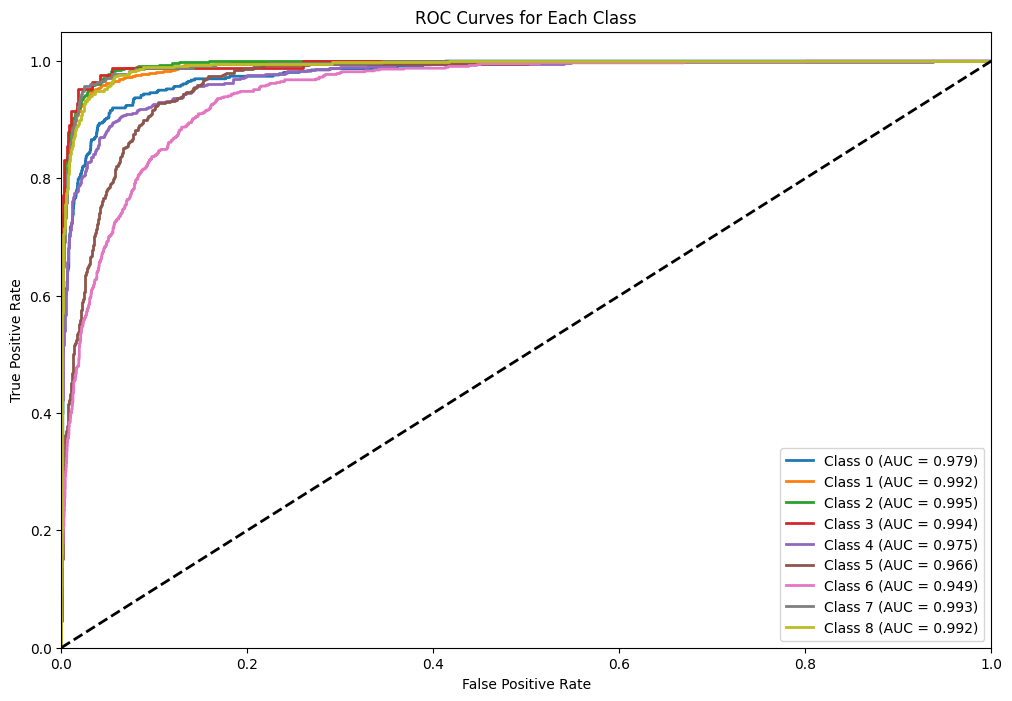

In [ ]:
# Get model predictions
y_pred_prob = model.predict(X_test_std)
# Plot ROC curves
plot_roc_curves(y_test_cat, y_pred_prob)

In [ ]:
# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Convert y_true from one-hot encoded to integer labels
    y_true_classes = np.argmax(y_true, axis=1)
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    plt.figure(figsize=(10, 8))
    # Adjust xticklabels and yticklabels to reflect the actual number of classes
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(9), yticklabels=np.arange(9))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

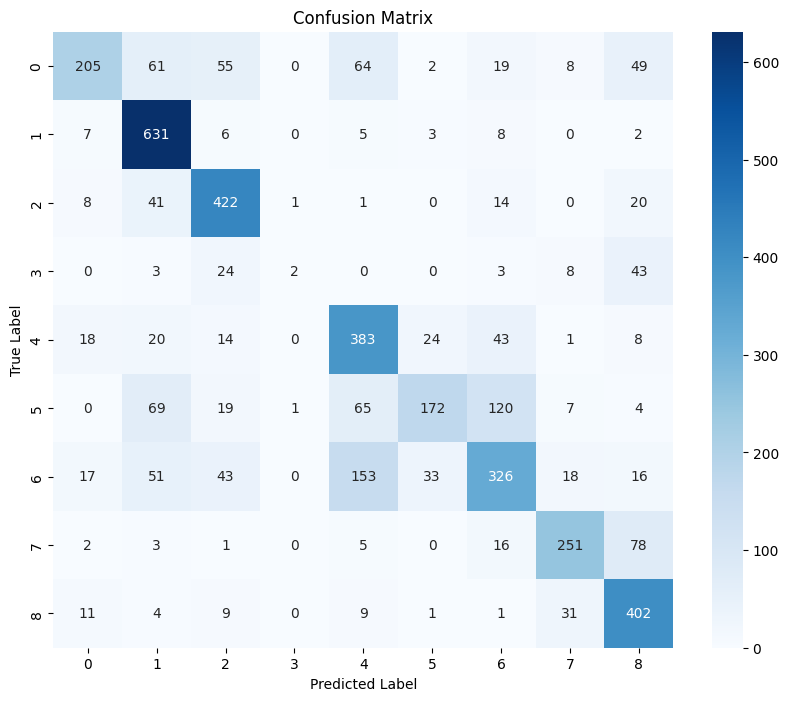

In [ ]:
# Plot confusion matrix
plot_confusion_matrix(y_test_cat, y_pred_prob)